# LangGraphStudio - MultiAgent

- Author: [Taylor(Jihyun Kim)](https://github.com/Taylor0819)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/20-LangGraphStudio-MultiAgent.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/20-LangGraphStudio-MultiAgent.ipynb)



## Overview

This notebook demonstrates how to build a **Multi-agent workflow** by integrating `LangChain` with `LangGraph Studio`, allowing you to orchestrate multiple specialized agents for gathering, analyzing, and synthesizing information. In this tutorial, we focus on researching a specific person, their professional background, and the company they work for, as well as generating relevant follow-up questions or interview prompts.

By visualizing this agent workflow in `LangGraph Studio`, you can easily debug, modify, and extend the pipeline. Each agent’s output can be inspected step by step, making it straightforward to add new components or adjust the process flow.

![Langgraph Studio](./assets/20-LangGraphStudio-MultiAgent-01.png)

### Table of Contents

- [Overview](#overview)
- [Environement Setup](#environment-setup)
- [What is LangGraph Studio](#what-is-langgraph-studio)
- [Building a Multi-Agent Workflow](#building-a-multi-agent-workflow)
- [How to connect a local agent to LangGraph Studio](#how-to-connect-a-local-agent-to-langgraph-studio)
- [Demo](#demo)


### References
- [LangGraph Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/)
- [Langchain-ai People Researcher Github](https://github.com/langchain-ai/people-researcher/tree/main)
----

## Environment Setup
Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]** 

- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials.
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.


In [44]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [45]:
# Install required packages
from langchain_opentutorial import package

package.install(
    ["langsmith", "langchain_anthropic", "langgraph", "tavily-python", "kora"],
    verbose=False,
    upgrade=False,
)


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [46]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "ANTHROPIC_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "20-LangGraphStudio-MultiAgent",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `ANTHROPIC_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [47]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## What is LangGraph Studio

`LangGraph Studio` offers a new way to develop LLM applications by providing a specialized agent IDE that enables visualization, interaction, and debugging of complex agentic applications.

With visual graphs and the ability to edit state, you can better understand agent workflows and iterate faster. `LangGraph Studio` integrates with LangSmith so you can collaborate with teammates to debug failure modes.

To use LangGraph Studio, make sure you have a [project with a LangGraph app](https://langchain-ai.github.io/langgraph/cloud/deployment/setup/) set up.

The desktop application only supports `macOS`. Other users can run a local LangGraph server and use the `web studio`. 

We also depend on `Docker Engine` to be running, currently we only support the following runtimes:

- [Docker Desktop](https://docs.docker.com/engine/install/)
- [Orbstack](https://orbstack.dev/)

LangGraph Studio requires docker-compose version 2.22.0+ or higher. 

Please make sure you have `Docker Desktop` or `Orbstack` installed and running before continuing.

In this tutorial, we have installed and are using `Docker Desktop` as our container runtime environment.


![Using LangGraph Studio](./assets/20-LangGraphStudio-MultiAgent-02.png)

## Building a Multi-Agent Workflow

Our system implements a sophisticated multi-agent workflow, organized into four main categories:

### 1. Personal Information Research 👤
- **Query Generator** (`generate_queries`)
  - Role: Generates search queries based on personal information (name, email, company)
  - Output: Set of optimized search queries

- **Personal Researcher** (`research_person`)
  - Role: Performs web searches using generated queries
  - Output: Summary of key information about the target person

### 2. Project Analysis 📊
- **Project Query Generator** (`extract_project_queries`)
  - Role: Analyzes personal research notes to identify project-related queries
  - Output: Project-focused search queries

- **Project Researcher** (`research_projects`)
  - Role: Collects and analyzes project information
  - Output: Detailed project information and insights

### 3. Company Research 🏢
- **Company Query Generator** (`generate_queries_for_company`)
  - Role: Creates customized search queries for gathering company information
  - Output: Company-related optimized search queries

- **Company Researcher** (`research_company`)
  - Role: Gathers company background and context information
  - Output: Comprehensive company profile

### 4. Integration & Analysis 🔄
- **Information Integrator** (`combine_notes`)
  - Role: Integrates all research results (personal, projects, company)
  - Output: Consolidated comprehensive report

- **Question Generator** (`generate_questions`)
  - Role: Generates interview questions based on integrated data
  - Output: Set of customized interview questions

- **Quality Controller** (`reflection`)
  - Role: Reviews data completeness and identifies areas for improvement
  - Output: Quality report and additional research needs

In [48]:
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_anthropic import ChatAnthropic

rate_limiter = InMemoryRateLimiter(
    requests_per_second=4,
    check_every_n_seconds=0.1,
    max_bucket_size=10, 
)

llm = ChatAnthropic(
    model="claude-3-5-sonnet-latest", temperature=0, rate_limiter=rate_limiter
)

In [49]:
# Get tavily api key
from tavily import AsyncTavilyClient
# Search
tavily_async_client = AsyncTavilyClient()


In [50]:
from dataclasses import dataclass, field
from typing import Any, Optional, Annotated
from pydantic import BaseModel, Field
import operator
from pydantic import BaseModel

class Person(BaseModel):
    """A class representing a person to research."""

    name: Optional[str] = None
    """The name of the person."""
    company: Optional[str] = None
    """The current company of the person."""
    linkedin: Optional[str] = None
    """The Linkedin URL of the person."""
    email: str
    """The email of the person."""
    role: Optional[str] = None
    """The current title of the person."""

@dataclass(kw_only=True)
class InputState:
    """Input state defines the interface between the graph and the user (external API)."""

    person: Person
    "Person to research."

    user_notes: Optional[dict[str, Any]] = field(default=None)
    "Any notes from the user to start the research process."


@dataclass(kw_only=True)
class OverallState:
    """Input state defines the interface between the graph and the user (external API)."""

    person: Person
    "Person to research provided by the user."

    user_notes: str = field(default=None)
    "Any notes from the user to start the research process."

    search_queries: list[str] = field(default=None)
    "List of generated search queries to find relevant information"

    # Add default values for required fields
    completed_notes: Annotated[list, operator.add] = field(default_factory=list)
    "Notes from completed research related to the schema"

    info: dict[str, Any] = field(default=None)
    """
    A dictionary containing the extracted and processed information
    based on the user's query and the graph's execution.
    This is the primary output of the enrichment process.
    """
    Questions: list[str] = field(default=None)

    is_satisfactory: bool = field(default=None)
    "True if all required fields are well populated, False otherwise"
    
    combined_notes: str = field(default_factory=str)
    "Consolidated research notes combining all gathered information into a single coherent document."

    project_queries: list[str] = field(default_factory=list)
    "List of search queries specifically focused on finding project-related information."

    company_search_queries: list[str] = field(default=None)
    "List of search queries generated for gathering company-specific information."

    reflection_steps_taken: int = field(default=0)
    "Number of times the reflection node has been executed"


@dataclass(kw_only=True)
class OutputState:
    """The response object for the end user.

    This class defines the structure of the output that will be provided
    to the user after the graph's execution is complete.
    """

    info: dict[str, Any]
    """
    A dictionary containing the extracted and processed information
    based on the user's query and the graph's execution.
    This is the primary output of the enrichment process.
    """


In [51]:
class Queries(BaseModel):
    queries: list[str] = Field(
        description="List of search queries.",
    )

class ReflectionOutput(BaseModel):
    is_satisfactory: bool = Field(
        description="True if all required fields are well populated, False otherwise"
    )
    search_queries: list[str] = Field(
        description="If is_satisfactory is False, provide 1-3 targeted search queries to find the missing information"
    )
    reasoning: str = Field(description="Brief explanation of the assessment")

In [52]:
def deduplicate_and_format_sources(
    search_response, max_tokens_per_source, include_raw_content=True
):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.

    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results

    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response["results"]
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and "results" in response:
                sources_list.extend(response["results"])
            else:
                sources_list.extend(response)
    else:
        raise ValueError(
            "Input must be either a dict with 'results' or a list of search results"
        )

    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source["url"] not in unique_sources:
            unique_sources[source["url"]] = source

    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += (
            f"Most relevant content from source: {source['content']}\n===\n"
        )
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get("raw_content", "")
            if raw_content is None:
                raw_content = ""
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"

    return formatted_text.strip()



In [53]:
import os
from dataclasses import dataclass, fields
from typing import Any, Optional
from langchain_core.runnables import RunnableConfig

@dataclass(kw_only=True)
class Configuration:
    max_search_queries: int = 3
    max_search_results: int = 3
    max_reflection_steps: int = 0

    @classmethod
    def from_runnable_config(cls, config: Optional[RunnableConfig] = None) -> "Configuration":
        configurable = config["configurable"] if config and "configurable" in config else {}
        values: dict[str, Any] = {
            "max_search_queries": configurable.get("max_search_queries", 3),
            "max_search_results": configurable.get("max_search_results", 3),
            "max_reflection_steps": configurable.get("max_reflection_steps", 0),
        }
        return cls(**values)

In [54]:
QUERY_WRITER_PROMPT = """ You are a search query generator tasked with creating targeted search queries to gather specific information about a person.

  Here is the person you are researching: {person}

  Generate at most {max_search_queries} search queries that will help gather the following information:

  <user_notes>
  {user_notes}
  </user_notes>

  Your query should:
  1. Make sure to look up the right name
  2. Use context clues as to the company the person works at (if it isn't concretely provided)
  3. Do not hallucinate search terms that will make you miss the persons profile entirely
  4. Take advantage of the Linkedin URL if it exists, you can include the raw URL in your search query as that will lead you to the correct page guaranteed.

  Create a focused query that will maximize the chances of finding schema-relevant information about the person.
  Remember we are interested in determining their work experience mainly."""


In [55]:
# generate queries
from langchain_core.runnables import RunnableConfig
from typing import cast

def generate_queries(state: OverallState, config: RunnableConfig) -> dict[str, Any]:
    """Generate search queries based on the user input and extraction schema."""
    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    max_search_queries = configurable.max_search_queries

    # Generate search queries
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    person_str = f"Email: {state.person['email']}"
    if "name" in state.person:
        person_str += f" Name: {state.person['name']}"
    if "linkedin" in state.person:
        person_str += f" LinkedIn URL: {state.person['linkedin']}"
    if "role" in state.person:
        person_str += f" Role: {state.person['role']}"
    if "company" in state.person:
        person_str += f" Company: {state.person['company']}"

    query_instructions = QUERY_WRITER_PROMPT.format(
        person=person_str,
        user_notes=state.user_notes,
        max_search_queries=max_search_queries,
    )

    # Generate queries
    results = cast(
        Queries,
        structured_llm.invoke(
            [
                {"role": "system", "content": query_instructions},
                {
                    "role": "user",
                    "content": "Please generate a list of search queries related to the schema that you want to populate.",
                },
            ]
        ),
    )

    # Queries
    query_list = [query for query in results.queries]
    return {"search_queries": query_list}


In [56]:
SEARCH_COMPANY_PROMPT = """You are a search query generator tasked with creating targeted search queries to gather specific information about a company.

  Person and Company Information: {person}

  Additional Context:
  {user_notes}

  Your query should:
  1. Focus on finding detailed company information and recent developments
  2. Look for company products, services, and main business areas
  3. Search for company culture, work environment, and growth trajectory
  4. Include specific company name variations and common abbreviations if known

  Constraints:
  1. Generate at most {max_search_queries} unique and meaningful queries
  2. Do not use generic terms that might dilute search results
  3. Prioritize recent company information (within last 2 years)
  4. Include company name in each query for better targeting

  Create focused queries that will maximize the chances of finding comprehensive company information.
  Remember we are interested in understanding the company's business context, culture, and market position.
"""

In [57]:
import asyncio

async def generate_queries_for_company(state: OverallState, config: RunnableConfig) -> dict[str, Any]:
    """
    Generate search queries specifically for the company, 
    possibly merging with user-provided queries (company_queries in state).
    """

    configurable = Configuration.from_runnable_config(config)
    max_search_queries = configurable.max_search_queries

    person_str = f"Email: {state.person['email']}"
    if "name" in state.person:
        person_str += f" Name: {state.person['name']}"
    if "linkedin" in state.person:
        person_str += f" LinkedIn URL: {state.person['linkedin']}"
    if "role" in state.person:
        person_str += f" Role: {state.person['role']}"
    if "company" in state.person:
        person_str += f" Company: {state.person['company']}"


    structured_llm = llm.with_structured_output(Queries)  # Queries: pydantic model for array of strings

    prompt = SEARCH_COMPANY_PROMPT.format(
        person=person_str,
        user_notes=state.user_notes,
        max_search_queries=max_search_queries,
    )

    llm_result = cast(
        Queries,
        await structured_llm.ainvoke(
            [
                {"role": "system", "content": prompt},
                {
                    "role": "user",
                    "content": "Generate company-related search queries now.",
                },
            ]
        )
    )

    generated_queries = [q for q in llm_result.queries]

    return {"company_search_queries": generated_queries}

In [58]:
COMPANY_INFO_PROMPT = """You are doing web research on company.

  The following schema shows the type of information we're interested in:

  You have just scraped website content. Your task is to take clear, organized notes about a company, focusing on topics relevant to our interests.

  <Website contents>
  {content}
  </Website contents>

  Here are any additional notes from the user:
  <user_notes>
  {user_notes}
  </user_notes>

  Please provide detailed research notes that:
  1. Are well-organized and easy to read
  2. Include specific facts, dates, and figures when available
  3. Maintain accuracy of the original content
  4. Note when important information appears to be missing or unclear

  Remember: Just take clear notes that capture all relevant information."""

In [59]:
async def research_company(state: OverallState, config: RunnableConfig) -> dict[str, Any]:
    """
    Use 'company_search_queries' to search relevant info about the company,
    then produce 'company_notes'.
    """

    configurable = Configuration.from_runnable_config(config)
    max_search_results = configurable.max_search_results

    # Web search
    search_tasks = []
    for query in state.company_search_queries:
        search_tasks.append(
            tavily_async_client.search(
                query,
                days=360,
                max_results=max_search_results,
                include_raw_content=True,
                topic="general",
            )
        )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(
        search_docs, max_tokens_per_source=1000, include_raw_content=True
    )

    p = COMPANY_INFO_PROMPT.format(
        content=source_str,
        user_notes=state.user_notes,
    )
    result = await llm.ainvoke(p)
    return {"company_notes": str(result.content)}

In [60]:
INFO_PROMPT = """You are doing web research on people, {people}.

  The following schema shows the type of information we're interested in:

  You have just scraped website content. Your task is to take clear, organized notes about a person, focusing on topics relevant to our interests.

  <Website contents>
  {content}
  </Website contents>

  Here are any additional notes from the user:
  <user_notes>
  {user_notes}
  </user_notes>

  Please provide detailed research notes that:
  1. Are well-organized and easy to read
  2. Focus on topics mentioned in the schema
  3. Include specific facts, dates, and figures when available
  4. Maintain accuracy of the original content
  5. Note when important information appears to be missing or unclear

  Remember: Don't try to format the output to match the schema - just take clear notes that capture all relevant information."""


In [61]:
async def research_person(state: OverallState, config: RunnableConfig) -> dict[str, Any]:
    """Execute a multi-step web search and information extraction process.

    This function performs the following steps:
    1. Executes concurrent web searches using the Tavily API
    2. Deduplicates and formats the search results
    """

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    max_search_results = configurable.max_search_results

    # Web search
    search_tasks = []
    for query in state.search_queries:
        search_tasks.append(
            tavily_async_client.search(
                query,
                days=360,
                max_results=max_search_results,
                include_raw_content=True,
                topic="general",
            )
        )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(
        search_docs, max_tokens_per_source=1000, include_raw_content=True
    )

    # Generate structured notes relevant to the extraction schema
    p = INFO_PROMPT.format(
        content=source_str,
        people=state.person,
        user_notes=state.user_notes,
    )
    result = await llm.ainvoke(p)
    return {"completed_notes": [str(result.content)]}


In [62]:
SEARCH_PROJECTS_PROMPT = """You have the following notes about a person:

{completed_notes}

From these notes, extract up to 3 specific search queries that would help us find more detailed information
about projects, case studies, or portfolio items mentioned or implied in the notes.

Generate at most {max_search_queries} search queries that will help gather the following information:

Output them as JSON in the format: {{"queries": ["query1", "query2", ...]}}.
"""

In [63]:
async def extract_project_queries(state: OverallState, config: RunnableConfig) -> dict[str, Any]:
    """
    Examine `state.completed_notes` to identify potential project-based keywords or queries,
    then return them as a list so we can further search Tavily.
    """
    configurable = Configuration.from_runnable_config(config)
    max_search_queries = configurable.max_search_queries

    # 2) We'll ask LLM to parse out project-related queries
    structured_llm = llm.with_structured_output(Queries)  # Re-using your Queries pydantic model

    prompt = SEARCH_PROJECTS_PROMPT.format(
        completed_notes = state.completed_notes,
        max_search_queries = max_search_queries,
    )

    llm_result = await structured_llm.ainvoke(
        [
            {"role": "system", "content": prompt},
            {"role": "user", "content": "Please provide the project-related queries now."},
        ]
    )

    # 3) Return the queries
    return {"project_queries": llm_result.queries if llm_result else []}


In [64]:
PROJECT_INFO_PROMPT = """You are doing additional web research on projects by {people}.

Focus on details about important projects they have worked on. Gather:
- project name
- relevant context or goals
- timeline
- major accomplishments
- technologies used
- challenges faced

Website contents:
{content}

Return your notes in a well-structured format that could be used for interview preparation.
"""

In [65]:
async def research_projects(state: OverallState, config: RunnableConfig) -> dict[str, Any]:
    """
    Execute a multi-step web search focusing on the person's projects,
    guided by the project queries extracted from `completed_notes`.
    """

    # 1) Retrieve the queries from state
    project_queries = getattr(state, "project_queries", [])
    if not project_queries:
        return {"project_notes": "No project queries found. Please run extract_project_queries first."}

    # 2) Set up concurrency
    configurable = Configuration.from_runnable_config(config)
    max_search_results = configurable.max_search_results

    search_tasks = []
    for query in project_queries:
        search_tasks.append(
            tavily_async_client.search(
                query,
                days=360,
                max_results=max_search_results,
                include_raw_content=True,
                topic="general",
            )
        )

    # 3) Execute all searches concurrently
    search_results = await asyncio.gather(*search_tasks)

    # 4) Format & deduplicate
    source_str = deduplicate_and_format_sources(
        search_results, max_tokens_per_source=1000, include_raw_content=True
    )

    # 5) Summarize the project details with LLM
    prompt = PROJECT_INFO_PROMPT.format(
        people=state.person,
        content=source_str,
    )
    llm_result = await llm.ainvoke(prompt)

    return {"project_notes": str(llm_result.content)}


In [66]:
COMBINE_ALL_PROMPT = """We have three sets of notes:

1) Person Notes:
{person_notes}

2) Company Notes:
{company_notes}

3) Project Notes:
{project_notes}

Please merge these notes into a single coherent summary. 
Remove any duplicate or conflicting information. 
The result should flow logically, covering person's details, the company background, and key project info.
"""

async def combine_notes(state: OverallState) -> dict[str, Any]:
    """
    Merge the notes from research_person (person_notes) and research_projects (project_notes)
    into a single cohesive note.
    """
    person_notes = getattr(state, "completed_notes", "")
    company_notes = getattr(state, "company_notes", "")
    project_notes = getattr(state, "project_notes", "")

    prompt = COMBINE_ALL_PROMPT.format(
        person_notes=person_notes,
        company_notes=company_notes,
        project_notes=project_notes,
    )
    llm_result = await llm.ainvoke(prompt) 

    return {"combined_notes": str(llm_result.content)}
    

In [67]:
GENERATE_QUESTIONS_PROMPT = """Based on the following combined note:
{combined_notes}

Create a list of interview questions that focus on this person's experiences, 
skills, and the project/product details mentioned. Format them as:
Q1: ...
Q2: ...
Q3: ...
"""

async def generate_questions(state: OverallState) -> dict[str, Any]:
    """
    Use the combined notes to generate a set of interview questions.
    """
    combined_notes = getattr(state, "combined_notes", "")
    if not combined_notes:
        return {"Questions": "No combined notes available. Please run combine_notes first."}

    prompt = GENERATE_QUESTIONS_PROMPT.format(
        combined_notes=combined_notes
    )
    llm_result = await llm.ainvoke(prompt)

    return {"Questions": str(llm_result.content)}

In [68]:
REFLECTION_PROMPT = """
  You are verifying if the following interview question is reasonably supported by the combined notes.
  If the question is even partially related to or inspired by the notes, set `is_satisfactory` to True.
  Only set `is_satisfactory` to False if it clearly contradicts or has no logical connection.

  <Question>
  {Question}
  </Question>

  <combined_notes>
  {combine_notes}
  </combined_notes>

  Important:
  - If any part of the combined notes is relevant to this question, consider it supported.
  - Only answer with 'true' or 'false' as is_satisfactory. Provide a brief explanation.
"""

In [69]:
def reflection(state: OverallState) -> dict[str, Any]:
    """
    Analyze the quality and completeness of the gathered information.
    """
    structured_llm = llm.with_structured_output(ReflectionOutput)
    system_prompt = REFLECTION_PROMPT.format(
        Question=state.Questions,
        combine_notes=state.combined_notes
    )
    result = structured_llm.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": "Produce a structured reflection output."},
        ]
    )
    result = cast(ReflectionOutput, result)
    if result.is_satisfactory:
        return {"is_satisfactory": result.is_satisfactory}
    else:
        return {
            "is_satisfactory": result.is_satisfactory,
            "reflection_steps_taken": state.reflection_steps_taken + 1,
            "reasoning": result.reasoning
        }

In [70]:
from typing import Literal
from langgraph.graph import END

def route_from_reflection(
    state: OverallState, config: RunnableConfig
) -> Literal[END, "generate_questions"]:  # type: ignore
    """Route the graph based on the reflection output."""
    configurable = Configuration.from_runnable_config(config)

    # If we have satisfactory results, end the process
    if state.is_satisfactory:
        return END

    # If results aren't satisfactory but we haven't hit max steps, continue research
    if state.reflection_steps_taken <= configurable.max_reflection_steps:
        return "generate_questions"

    return END

In [71]:
from langgraph.graph import StateGraph, START

# Add nodes and edges
builder = StateGraph(
    OverallState,
    input=InputState,
    output=OutputState,
    config_schema=Configuration,
)

builder.add_node("generate_queries", generate_queries)
builder.add_node("research_person", research_person)
builder.add_node("combine_notes", combine_notes)
builder.add_node("research_projects", research_projects)
builder.add_node("generate_questions", generate_questions)
builder.add_node("reflection", reflection)
builder.add_node("generate_queries_for_company", generate_queries_for_company)
builder.add_node("research_company", research_company)
builder.add_node("extract_project_queries", extract_project_queries)

# -- Node Connections (Edges) ---

builder.add_edge(START, "generate_queries")
builder.add_edge("generate_queries", "research_person")
builder.add_edge("research_person", "extract_project_queries")
builder.add_edge("extract_project_queries", "research_projects")

builder.add_edge(START, "generate_queries_for_company")
builder.add_edge("generate_queries_for_company", "research_company")

builder.add_edge(["research_company", "research_projects"], "combine_notes")

builder.add_edge("combine_notes", "generate_questions")
builder.add_edge("generate_questions", "reflection")
builder.add_conditional_edges("reflection", route_from_reflection)

# Compile the graph
graph = builder.compile()

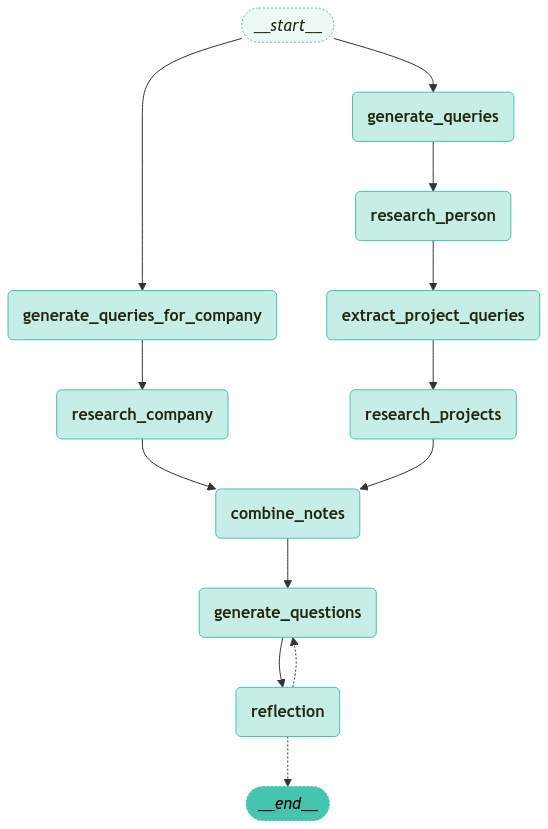

In [72]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(graph)

In [79]:
import asyncio
from typing import Any, Dict, List, Callable
from collections import defaultdict
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph

async def astream_graph(
    graph: CompiledStateGraph,
    inputs: Dict[str, Any],
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable[[Dict[str, str]], None] = None,
):
    """
    This function executes a compiled LangGraph and collects the output chunks for each node,
    storing them in memory. After the entire graph execution finishes, it prints the results
    for each node in the order they first appeared.

    **Key Point:**
    - This approach **disables real-time streaming** (no partial outputs to the console as they arrive).
      Instead, all partial outputs are aggregated and printed only after graph execution is complete.
      This helps to avoid interleaved or mixed outputs when different nodes run in parallel.

    **Note:** If you run the same graph in **LangGraph Studio**, you can observe real-time chunk streaming.
    However, with this function, we intentionally buffer all chunks to produce a cleaner final output
    for each node.
    """
    # Nodes to exclude from output
    excluded_nodes = {
        "generate_queries",
        "generate_queries_for_company",
        "extract_project_queries",
        "reflection"
    }

    # Keep track of the order in which nodes appear
    node_order: List[str] = []
    # A dictionary to store buffered text for each node
    node_buffers: Dict[str, str] = defaultdict(str)

    # Consume the asynchronous stream of chunks
    async for chunk_msg, metadata in graph.astream(inputs, config, stream_mode="messages"):
        curr_node = metadata["langgraph_node"]

        # If node_names is specified and curr_node is not in it, skip processing
        if node_names and curr_node not in node_names:
            continue

        # If this node is excluded, skip
        if curr_node in excluded_nodes:
            continue

        # If callback is provided, you could handle partial chunks in real time.
        # But here, we want to buffer everything until completion, so we skip.
        if curr_node not in node_order:
            node_order.append(curr_node)

        # Accumulate chunks in the buffer for this node
        node_buffers[curr_node] += chunk_msg.content

    # After the entire graph finishes, output results for each node in the order they first appeared
    for node in node_order:
        # If the node is excluded, skip it
        if node in excluded_nodes:
            continue

        # Print final aggregated content for this node
        print("\n" + "=" * 50)
        print(f"🔄 Node: \033[1;36m{node}\033[0m 🔄")
        print("- " * 25)
        print(node_buffers[node], end="", flush=True)

In [78]:
config = RunnableConfig(
    recursion_limit=10,
    configurable={
        "max_search_queries": 3,
        "max_search_results": 3,
        "max_reflection_steps": 1,
    },
)

input_data = {
    "person": {
        "email": "jhkim@reversemountain.co.kr",

    }}


# This function buffers all partial outputs for each node and prints them only after the entire graph execution completes. 
# Hence, if the graph takes a while to run, say 40-50 seconds, you won't see any intermediate output until it finishes!
await astream_graph(graph, input_data, config)


🔄 Node: research_company 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
RESEARCH NOTES: REVERSE MOUNTAIN / TICKI TACKA

COMPANY OVERVIEW
- Company Name: Reverse Mountain Corp (리버스마운틴)
- Founded: August 2021
- Location: Seoul, South Korea (Jongno Youth Startup Center)
- CEO: Gyeongmin KIM
- Current Employees: 9 (as of 2024)

CORE PRODUCT
- Product Name: Ticki Tacka
- Type: AI-powered enterprise project control and performance optimization system
- Key Features:
  * Cascading goals system (team objectives to weekly KPIs)
  * Transparent contribution tracking
  * Weekly evaluation and feedback system
  * Focus on workplace engagement for 20-30 age demographic

COMPANY HISTORY
- Initially started with two hobby platforms (Palette and Hobby Picker)
- Pivoted to workplace solutions after identifying workplace pain points
- Current focus on enterprise performance management solutions

FUNDING & ACHIEVEMENTS
- Investment Stage: Seed
- Recent Developments:
  * Received TIPS (Tech Incubat

### Jupyter Notebook Code Cell Extractor

This script converts `Jupyter Notebook` cells into a `Python script` with the following features:
1. Converts pip install magic commands into executable Python code
2. Removes or comments out visualization-related code
3. Handles cell deduplication
4. Processes cells up to the graph compilation
5. Maintains code organization and readability

This conversion is necessary because `LangGraph Studio` requires Python `(.py) file`s for execution. This script helps transform our tutorial notebook into the correct format while maintaining all functionality.

Key Features:
- Automatic package installation code generation
- Cell content deduplication
- Selective cell processing
- Magic command handling
- Proper formatting for `LangGraph Studio` compatibility

In [75]:
import json
import os

def extract_code_cells(notebook_path, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)
    
    def transform_cell(cell_source):
        """Transform Jupyter notebook code cell content"""
        if isinstance(cell_source, list):
            cell_source = ''.join(cell_source)
        
        # Remove %%capture magic
        if cell_source.startswith('%%capture'):
            cell_source = '\n'.join(cell_source.split('\n')[1:])
        
        # Transform %pip install commands to executable code
        if cell_source.strip().startswith('%pip install'):
            packages = [pkg.strip() for pkg in cell_source.replace('%pip install', '').strip().split()]
            if not packages:
                return ""
            # Remove duplicates
            packages = list(dict.fromkeys(packages))
            
            return f'''import sys
import subprocess

def pip_install(package: str):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

if __name__ == "__main__":
    packages = {packages}
    for pkg in packages:
        pip_install(pkg)
'''
        
        # Handle visualization code
        lines = cell_source.split('\n')
        new_lines = []
        for line in lines:
            if 'from langchain_opentutorial.graphs import visualize_graph' in line \
               or 'visualize_graph(graph)' in line:
                new_lines.append('# ' + line)
            else:
                new_lines.append(line)
        
        return '\n'.join(new_lines)
    
    # Prevent duplicate cells
    seen_cells = set()
    unique_cells = []
    found_compile = False
    
    # Process notebook cells
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            cell_content = ''.join(cell['source'])
            
            # Set flag when compile is found
            if 'graph = builder.compile()' in cell_content:
                found_compile = True
            
            # Handle duplicates
            if cell_content not in seen_cells:
                seen_cells.add(cell_content)
                transformed = transform_cell(cell['source'])
                if transformed.strip():
                    unique_cells.append(transformed)
            
            # Stop processing after compile
            if found_compile:
                break
    
    # Save transformed code
    with open(output_path, 'w', encoding='utf-8') as f:
        for cell in unique_cells:
            f.write(cell + '\n\n')

# Usage example
notebook_file = "./20-LangGraphStudio-MultiAgent.ipynb"
output_file = "./langgraph_studio/output_script.py"
extract_code_cells(notebook_file, output_file)

# How to connect a local agent to LangGraph Studio

**Connection Options**
There are two ways to connect your local agent to LangGraph Studio:

- [Development Server](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#development-server-with-web-ui): Python package, all platforms, `no Docker`
- [LangGraph Desktop](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#desktop-app): `Application`, `Mac only`, `requires Docker`

In this guide we will cover how to use the development server as that is generally an easier and better experience.


[LangGraph Studio Desktop (Beta)](https://github.com/langchain-ai/langgraph-studio)

The desktop application only supports macOS. Other users can [run a local LangGraph server and use the web studio](https://langchain-ai.github.io/langgraph/tutorials/langgraph-platform/local-server/#langgraph-studio-web-ui). We also depend on Docker Engine to be running, currently we only support the following runtimes:

[LangGraph Studio Download for MacOS](https://studio.langchain.com/)

### Setup your application

First, you will need to setup your application in the proper format. This means defining a langgraph.json file which contains paths to your agent(s). See [this guide](https://langchain-ai.github.io/langgraph/concepts/application_structure/) for information on how to do so.

Please make sure that all the required files for running LangGraph Studio are located in the `langgraph_studio` folder.

For this example, we will use this example [repository](https://github.com/langchain-ai/langgraph-example) here which uses a `requirements.txt` file for dependencies:

```bash
└── langgraph_studio 
    ├── .env
    ├── langgraph.json
    ├── output_script.py
    └── requirements.txt
```

As previously mentioned, we are using `Docker Desktop` , so please download it, launch the app, and make sure the Docker engine is running. Then, in `LangGraph Studio` , open the langgraph_studio folder.

![LangGraph Studio Setup](./assets/20-LangGraphStudio-MultiAgent-03.png)

After a short while, once the build completes successfully, you will see a screen similar to the one below.
![LangGraph Studio](./assets/20-LangGraphStudio-MultiAgent-04.png)

Now, let’s run a test. I’ll enter my actual company email address.
![LangGraph Studio Demo](./assets/20-LangGraphStudio-MultiAgent-05.png)

## Demo
Here is a demo video showing how it works in practice.

[LangGraph Studio Demo Video Link](https://www.dropbox.com/scl/fi/2ds4xihlbljr9peecllk0/langgrpah_studio_Demo.mov?rlkey=0be0ip4j2mtno9zpbk94t5kmh&st=uq905esp&dl=0)

### Output
Here are relevant interview questions based on the provided notes:

Technical Experience & Skills:

Q1: Could you describe your transition from data analysis at Tiffany & Co. to AI engineering, and how your previous experience informs your current work with LLMs and RAG systems?

Q2: What specific NLP challenges have you encountered while developing the "Ticki tacka" project control system, and how have you addressed them?

Q3: How do you balance your current studies in Statistics and Data Science with your role as an AI Engineer? What aspects of your coursework directly apply to your work?

Project & Product Specific:

Q4: Could you walk us through the core AI components of the "Ticki tacka" system and your role in its development?

Q5: What metrics or KPIs have you established to measure the effectiveness of the AI-powered workplace optimization solutions you're developing?

Language & Communication:

Q6: Given your Chinese and English language proficiencies, how do you leverage these skills in your current role, particularly in technical documentation or team collaboration?

Company Growth & Vision:

Q7: How has the recent seed funding and TIPS grant influenced your team's approach to AI development and project priorities?

Q8: What role do you see AI playing in workplace happiness and employee engagement, and how does this align with Reversemountain's mission?

Technical Implementation:

Q9: Could you describe your experience implementing RAG systems, and what challenges have you encountered in enterprise applications?

Q10: How do you approach the balance between model performance and practical business requirements in your AI solutions?


Wow, these interview questions are really well-tailored based on my past and current companies! 

I’d better make sure I don’t get caught off guard if they actually come up in an interview. 🤣